## Camera shaders

Various camera projections are illustrated, including user defined ray distribution.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

import numpy as np
from plotoptix import NpOptiX

Setup the raytracer:

In [2]:
width = 800
height = 500

def update_image(rt: NpOptiX) -> None:
    img.set_data(rt._img_rgba) # update figure directly accessing buffer where the device is storing the output data
    plt.draw()

rt = NpOptiX(on_launch_finished=update_image, width=width, height=height, start_now=False)

rt.set_param(min_accumulation_step=4,
             max_accumulation_frames=512)

Add some data. Not so fancy but should give a visual confirmation of changes to perspective lines and an up-down / left-right orientation.

In [3]:
rx = 10
rz = 8
n = 30

x = np.linspace(0, rx, n)
z = np.linspace(0, rz, n)

X, Z = np.meshgrid(x, z)

# positions of points
xyz = np.stack((X.flatten(), np.zeros(n*n), Z.flatten())).T

# sizes: increase with X (left to right in the image below)
r = 0.1 + (1 / n) * xyz[:,0]
# colors: darker with Y (top to down in the image below)
c = 0.95 - (0.9 / rz) * xyz[:,2]

rt.set_data("points", xyz, r=r, c=c, geom="Parallelepipeds")

rt.set_data("plane", [-10, -1, -10], u=[30, 0, 0], v=[0, 0, 30], c=0.9, geom="Parallelograms") # a wall behind cubes

rt.setup_area_light("light1", center=[15, 15, 4], target=[5, 0, 4], u=7, v=7, color=[9, 8, 7])

rt.set_ambient([0.1, 0.2, 0.4])
rt.set_background(0)

Custom projection is defined with ray angles in a texture. If the texture size coincides with the render view size, each ray is exactly defined by corresponding pixel in the texture, otherwise ray angles are interpolated. Ray angles are:
- u, horizontal deflection with respect to the camera axis (negative to the left, positive to the right)
- v, vertical deflection with respect to the camera axis (negative down, positive up).

Angles are in radians, scaled to map the range `(-pi;  pi)` to `(-1; 1)`.

In [4]:
fov = 50 # field of view (vertical), in degrees

# equirectangular projection
a_ratio = width / height
u = np.linspace(-0.5 * a_ratio * fov / 180, 0.5 * a_ratio * fov / 180, width)
v = np.linspace(0.5 * fov / 180, -0.5 * fov / 180, height)

V, U = np.meshgrid(v, u)

fi_tex = np.stack((U, V)).T

rt.set_texture_2d("fi_tex", fi_tex)

Setup  cameras (all modes except 360deg panorama, which would be `cam_type="Panoramic"`):

In [5]:
eye = [5, 10, 4]
tgt = [5, 0, 4]
up  = [0, 0, -1]

rt.setup_camera("cam7", cam_type="CustomProj", eye=eye, target=tgt, up=up, textures=["fi_tex"])
rt.setup_camera("cam6", cam_type="FisheyeChroma", eye=eye, target=tgt, up=up, fov=fov)
rt.setup_camera("cam5", cam_type="Fisheye", eye=eye, target=tgt, up=up, fov=fov)
rt.setup_camera("cam4", cam_type="Ortho", eye=eye, target=tgt, up=up, fov=fov)
rt.setup_camera("cam3", cam_type="ThinLensChroma", eye=eye, target=tgt, up=up, fov=fov, chroma_l=0, chroma_t=0.05)
rt.setup_camera("cam2", cam_type="ThinLensChroma", eye=eye, target=tgt, up=up, fov=fov) # default aberration values
rt.setup_camera("cam1", cam_type="ThinLens", eye=eye, target=tgt, up=up, fov=fov)

Show the output image here:

<IPython.core.display.Javascript object>


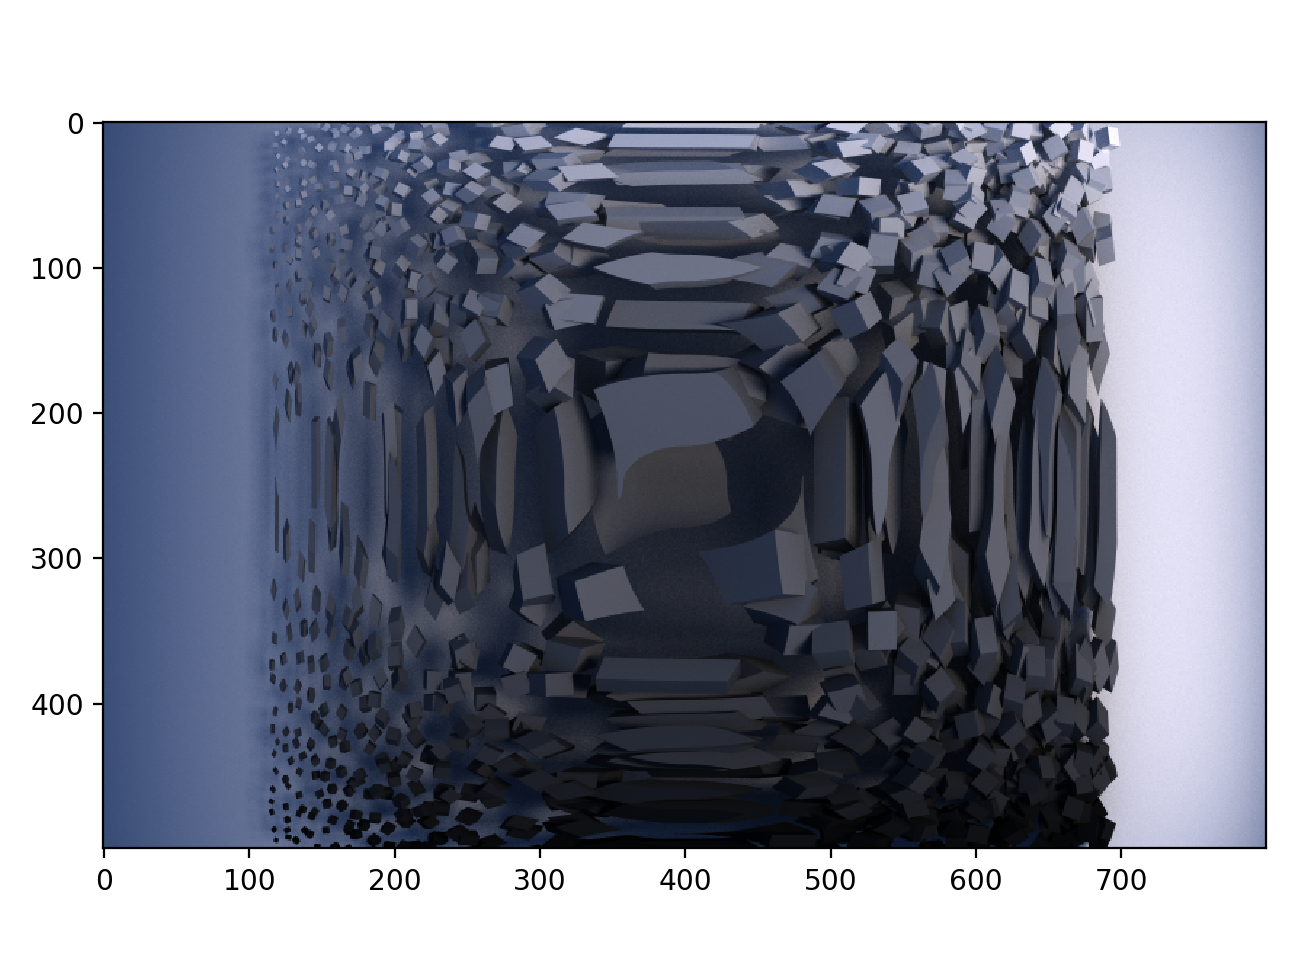

In [6]:
plt.figure(1)
img = plt.imshow(np.zeros((height,width,4)))
plt.tight_layout()

Start the ray tracing:

In [7]:
rt.start()

Change the active camera:

In [8]:
rt.set_current_camera("cam7") # try all cameras cam1...cam7

Modify the custom projection (run this with `cam7` active):

In [9]:
fi_tex2 = 6*np.multiply(np.sign(fi_tex), np.multiply(fi_tex, fi_tex))

rt.set_texture_2d("fi_tex", fi_tex2, refresh=True) # update texture content, data is copied directly to the device memory here

Close the ray-tracer.

In [10]:
rt.close()